In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')


In [2]:
def df_investigate(df):
  info = pd.DataFrame(df.count(), columns=['filled'])
  info['filled %'] = round(info['filled'] / len(df), 4)*100
  info['nunique'] = df.nunique()
  info['uniques'] = np.nan
  info['dtypes'] = df.dtypes
  for idx, row in info.iterrows():
    if row['nunique'] < 10:
      info.loc[idx, 'uniques'] = str(list(df[idx].unique()))
  return info

In [3]:
import boto3

session = boto3.Session() # Grabs session details directly from aws configuration in EC2 instance running the Notebook server
s3r = session.resource("s3")
bucket = s3r.Bucket('aida-project')
files=[]
for obj in bucket.objects.all():
  if obj.key.startswith("Covid"):
#    print(obj.key)
    if obj.key.endswith("csv"):
        files.append(obj.key)
for i,file in enumerate(files):
    print(i,"\t",file)

0 	 Covid-19/1/owid-covid-data.csv
1 	 Covid-19/2/covid-19-at.csv
2 	 Covid-19/2/covid-19-be.csv
3 	 Covid-19/2/covid-19-ch.csv
4 	 Covid-19/2/covid-19-cz.csv
5 	 Covid-19/2/covid-19-de.csv
6 	 Covid-19/2/covid-19-ecdc.csv
7 	 Covid-19/2/covid-19-england.csv
8 	 Covid-19/2/covid-19-fr.csv
9 	 Covid-19/2/covid-19-hu.csv
10 	 Covid-19/2/covid-19-ie.csv
11 	 Covid-19/2/covid-19-it.csv
12 	 Covid-19/2/covid-19-nl.csv
13 	 Covid-19/2/covid-19-no.csv
14 	 Covid-19/2/covid-19-pl.csv
15 	 Covid-19/2/covid-19-scotland.csv
16 	 Covid-19/2/covid-19-se.csv
17 	 Covid-19/2/covid-19-si.csv
18 	 Covid-19/2/covid-19-uk.csv
19 	 Covid-19/2/covid-19-wales.csv
20 	 Covid-19/3/time_series_covid19_confirmed_US.csv
21 	 Covid-19/3/time_series_covid19_confirmed_global.csv
22 	 Covid-19/3/time_series_covid19_deaths_US.csv
23 	 Covid-19/3/time_series_covid19_deaths_global.csv
24 	 Covid-19/3/time_series_covid19_recovered_global.csv
25 	 Covid-19/4/covid_jpn_metadata.csv
26 	 Covid-19/4/covid_jpn_prefecture.csv

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [5]:
file_nr = 0
selected_file = files[file_nr]

file_check = "s3://" + bucket.name + "/" + selected_file
df = pd.read_csv(file_check, error_bad_lines=False)
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,NaN,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


In [6]:
# dtype: object
# iso_code and continent: nan -> other
df_1 = df.copy()
cols_na = ['iso_code', 'continent','tests_units']
replace_na = ['Other','Other','Unknown']
for i in range(len(cols_na)):
    df_1[cols_na[i]] = df_1[cols_na[i]].fillna(replace_na[i])

# total_cases = prev value, new_cases = 0, new_cases_smoothed = following value, new_deaths = 0, total_deaths = 0 (check if missing value inbetween)
# new_deaths_smoothed = following value, for remaining new_deaths_smoothed and new_cases_smoothed set previous
df_2 = df_1.copy()
df_2['total_cases'] = df_2['total_cases'].fillna(method='ffill')
df_2['new_cases'] = df_2['new_cases'].fillna(0)
df_2['new_deaths'] = df_2['new_deaths'].fillna(0)
df_2['total_deaths'] = df_2['total_deaths'].fillna(0)
df_2['new_cases_smoothed'] = df_2['new_cases_smoothed'].fillna(method='bfill')
df_2['new_deaths_smoothed'] = df_2['new_deaths_smoothed'].fillna(method='bfill')
df_2['new_cases_smoothed'] = df_2['new_cases_smoothed'].fillna(method='ffill')
df_2['new_deaths_smoothed'] = df_2['new_deaths_smoothed'].fillna(method='ffill')

df_cleaned = df_2.copy()
iso_code='ABW'
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]

In [8]:
def optimize_SARIMA(parameters_list, d, D, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        print(param)
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], param[4])).fit(disp=-1)
        except:
            print("problem")
            break
#            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

# Optimize parameters

In [18]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(1, 2, 1)
d = 1
q = range(1, 2, 1)
P = range(2, 4, 1)
D = 1
Q = range(5, 7, 1)
s = range(14, 15, 1)
parameters = product(p, q, P, Q, s)
parameters_list = list(parameters)
print(parameters_list)
print(len(parameters_list))

[(1, 1, 2, 5, 14), (1, 1, 2, 6, 14), (1, 1, 3, 5, 14), (1, 1, 3, 6, 14)]
4


In [19]:
# SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)

result_df = optimize_SARIMA(parameters_list, 1, 1, df_iso.reset_index()['new_cases'])
result_df

(1, 1, 2, 5, 14)
(1, 1, 2, 6, 14)
(1, 1, 3, 5, 14)
(1, 1, 3, 6, 14)



,"(p,q)x(P,Q)",AIC
0,"(1, 1, 2, 5, 14)",2173.605786
1,"(1, 1, 2, 6, 14)",2175.790902
2,"(1, 1, 3, 5, 14)",2175.882470
3,"(1, 1, 3, 6, 14)",2177.633549


In [20]:
# final parameter set for modelling and prediction
p=1
d=1
q=1
P=2
D=1
Q=5
s=14

In [21]:
model = SARIMAX(df_iso.reset_index()['new_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)

In [22]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            SARIMAX Results                                             
========================================================================================================
Dep. Variable:                                        new_cases   No. Observations:                  257
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2, 3, 4, 5], 14)   Log Likelihood               -1076.803
Date:                                          Tue, 01 Dec 2020   AIC                           2173.606
Time:                                                  13:33:27   BIC                           2208.495
Sample:                                                       0   HQIC                          2187.660
                                                          - 257                                         
Covariance Type:                                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1453      0.067      2.177      0.029       0.014       0.276
ma.L1         -0.7740      0.050    -15.431      0.000      -0.872      -0.676
ar.S.L14      -0.2372      9.814     -0.024      0.981     -19.472      18.998
ar.S.L28       0.7424      6.378      0.116      0.907     -11.758      13.243
ma.S.L14      -0.5916     17.944     -0.033      0.974     -35.761      34.578
ma.S.L28      -0.9118     16.444     -0.055      0.956     -33.141      31.317
ma.S.L42       0.3102     10.073      0.031      0.975     -19.433      20.053
ma.S.L56      -0.0575      3.731     -0.015      0.988      -7.370       7.255
ma.S.L70       0.2560      5.279      0.048      0.961     -10.091      10.603
sigma2       359.3911   7951.665      0.045      0.964   -1.52e+04    1.59e+04
===================================================================================
Ljung-Box (Q):                      122.51   Jarque-Bera (JB):              1296.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              49.09   Skew:                             1.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

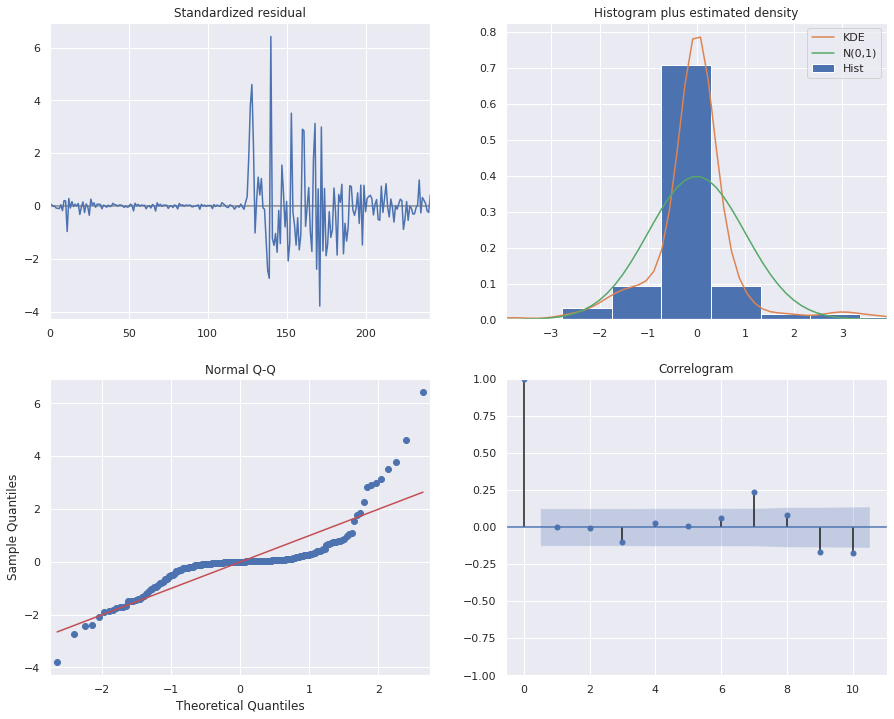

In [23]:
model.plot_diagnostics(figsize=(15,12));

In [25]:
df_tableau=df_iso.copy()
drop_cols=['total_cases','new_cases_smoothed', 'total_deaths', 'new_deaths', \
       'new_deaths_smoothed', 'total_cases_per_million', \
       'new_cases_per_million', 'new_cases_smoothed_per_million', \
       'total_deaths_per_million', 'new_deaths_per_million', \
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', \
       'icu_patients_per_million', 'hosp_patients', \
       'hosp_patients_per_million', 'weekly_icu_admissions', \
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', \
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', \
       'total_tests_per_thousand', 'new_tests_per_thousand', \
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', \
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index', \
       'population', 'population_density', 'median_age', 'aged_65_older', \
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty', \
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', \
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', \
       'life_expectancy', 'human_development_index']
df_tableau.drop(drop_cols, axis=1,inplace=True)
df_tableau

,iso_code,continent,location,date,new_cases
0,ABW,North America,Aruba,2020-03-13,2.0
1,ABW,North America,Aruba,2020-03-19,0.0
2,ABW,North America,Aruba,2020-03-20,2.0
3,ABW,North America,Aruba,2020-03-21,0.0
4,ABW,North America,Aruba,2020-03-22,0.0
...,...,...,...,...,...
252,ABW,North America,Aruba,2020-11-25,14.0
253,ABW,North America,Aruba,2020-11-26,27.0
254,ABW,North America,Aruba,2020-11-27,13.0
255,ABW,North America,Aruba,2020-11-28,17.0


In [26]:
model.fittedvalues

0       0.000000
1       1.999634
2       0.000679
3       1.999367
4       0.000640
         ...    
252     9.760133
253    25.120387
254    16.603962
255    21.763198
256    16.739349
Length: 257, dtype: float64

In [65]:
from datetime import timedelta

df_iso['arima_model'] = model.fittedvalues
df_tableau['predicted'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN


forecast = model.predict(start=df_iso.shape[0], end=df_iso.shape[0] + 13)
#forecast = df_iso['arima_model'].append(forecast)
last_known_date = pd.to_datetime(df_iso.loc[df_iso.shape[0]-1,'date'])


list_t = []

for i in range(14):
    t = (last_known_date + timedelta(days=i)).strftime("%Y-%m-%d")

    list_t.append(t)


df_to_add = pd.DataFrame(list(zip(list_t, forecast)), 
               columns =['date', 'predicted']) 




df_tableau_final = df_tableau.append(df_to_add)


bucket = s3r.Bucket('aida-project')
df_tableau_final.to_csv('predictions_for_tableau.csv', header=True, index=False)
bucket.upload_file(Filename="predictions_for_tableau.csv", Key='Covid-19/output/predictions_for_tableau.csv')




plt.figure(figsize=(15, 7.5))
#plt.plot(range(len(forecast)),forecast, color='r', label='model')
#plt.axvspan(len(df_iso), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso)),df_iso['new_cases'], label='actual')
plt.legend()
"""
shift_line=1
st=(y_end-y_start+1)*12
max0=max(forecast[st:st+13])+shift_line
max1=max(forecast[-13:-1])+shift_line
min0=min(forecast[st:st+13])-shift_line
min1=min(forecast[-13:-1])-shift_line
plt.plot([len(df_iso),len(forecast)],[max0,max1],c='black')
plt.plot([len(df_iso),len(forecast)],[max0,max0],c='black',linestyle='dotted')
plt.plot([len(df_iso),len(forecast)],[min0,min1],c='black')
plt.plot([len(df_iso),len(forecast)],[min0,min0],c='black',linestyle='dotted')
#plt.lines(min0,min1,c='black')
"""

plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

NameError: name 'df_fr' is not defined

In [59]:
model.predict(start=df_iso.shape[0], end=df_iso.shape[0] + 10)

257    12.778247
258    11.769209
259    18.096768
260    19.544183
261    15.802100
262    14.743599
263    19.391561
264    11.606125
265     8.063207
266    18.243440
267    26.750798
dtype: float64